## Copied and pasted from nn_scores.py

### Groups multiple models, like "CNN" and "DNN", multiple mode thresholds like "5%" and "10%"
### and plots mean with confidence interval

In [1]:
import argparse
import datetime
import glob
import logging
# works if ipympl is installed in kernel. Works with conda env NPL 2022b
from IPython.core.error import UsageError
try:
    %matplotlib widget
except UsageError:
    logging.error("matplotlib widget magic not supported in this kernel")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pdb
import seaborn as sns
import sys

sns.set_theme() # pretty axes background and gridlines

def nns(ifile):
    # abbreviate input file name for legend 
    ifile = ifile.replace(".scores.txt","")
    return ifile

def parse_args():
    # =============Arguments===================
    parser = argparse.ArgumentParser(description = "plot NN verification scores written by test_stormrpts_dnn.py, often in /glade/work/ahijevyc/NSC_objects/nn/.", formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('ifiles', nargs="+", type=argparse.FileType("r"), help="input file(s)")
    parser.add_argument("--ci", type=int, default=95, help="confidence interval. Show individual lines if ci=0")
    parser.add_argument("-d", "--debug", action="store_true", help="turn on debug mode")
    parser.add_argument("--ensmean", action="store_true", help="ensemble mean")
    parser.add_argument("--mask", type=str, nargs="+", help="only show this(these) mask value(s)")
    parser.add_argument("--nofineprint", action="store_true", help="no fine print (ci, time created, etc)")
    parser.add_argument("--nomem", action="store_true", help="don't plot individual fits, i.e. members")
    parser.add_argument("--ymax",type=float, help="maximum on y-axis")
    parser.add_argument("--ymin",type=float, help="minimum on y-axis")
    return parser

### To ensure input csv files are visible, you can symbolically link to /glade/work/ahijevyc/NSC_objects/nn

In [2]:
parser = parse_args()
# Load all 5% and 10% mode probabilities
args = parser.parse_args(args=glob.glob("nn/*0.05.scores.txt") + glob.glob("nn/*0.1.scores.txt"))

### Set variable to "bss" or "aps" or "auc"

In [3]:
ifiles      = args.ifiles
ci          = args.ci # default ci is 95
debug       = args.debug
ensmean     = True
mask        = args.mask
nofineprint = args.nofineprint
nomem       = True
variable    = "bss"
ymax        = args.ymax
ymin        = args.ymin

level = logging.INFO
if debug:
    level = logging.DEBUG
logging.basicConfig(format='%(asctime)s %(message)s', level=level)
logging.debug(args)



In [4]:
logging.info(f"Read {len(ifiles)} input files into Pandas DataFrame, with nn column = filename")
# if you try to read ifiles again without rewinding, it will fail with empty because it is at the end of the file.
[f.seek(0) for f in ifiles]
dfs = pd.concat([pd.read_csv(ifile,header=0).assign(nn=nns(ifile.name)) for ifile in ifiles], ignore_index=True) # ignore index or get duplicate indices

if mask is not None:
    dfs = dfs[dfs["mask"].isin(mask)]

# Append fold to mem and drop fold
dfs["mem"] = dfs["mem"] + "." + dfs["fold"]
dfs = dfs.drop(columns="fold")

# common prefix for nn
prefix = os.path.commonprefix(dfs["nn"].tolist())
# remove common prefix from nn (make it shorter) 
if len(ifiles) > 1: # otherwise nn is empty and doesn't trigger legend
    dfs["nn"] = dfs["nn"].str.replace(prefix,"",regex=False)
    
dfs["nn"] = dfs["nn"].str.extract(r'(.*fold)\..*$')

2022-10-13 13:26:35,627 Read 24 input files into Pandas DataFrame, with nn column = filename


In [5]:
# Break up mask string column into 4 substrings: model, mode, op, and thresh.
mask_details = dfs["mask"].str.extract(r'(?P<model>[A-Za-z]+)_(?P<mode>.*)(?P<op>[<>]=?)(?P<thresh>[0-9]+(?:\.[0-9]*)?%)')
mask_details

model               mode  op thresh
0       DNN       1_QLCS_nprob   <     5%
1       DNN       1_QLCS_nprob  >=     5%
2       DNN       1_QLCS_nprob   <     5%
3       DNN       1_QLCS_nprob  >=     5%
4       DNN       1_QLCS_nprob   <     5%
...     ...                ...  ..    ...
43195   DNN  1_Supercell_nprob  >=    10%
43196   DNN  1_Supercell_nprob   <    10%
43197   DNN  1_Supercell_nprob  >=    10%
43198   DNN  1_Supercell_nprob   <    10%
43199   DNN  1_Supercell_nprob  >=    10%

[43200 rows x 4 columns]

In [6]:
dfs = pd.concat([dfs,mask_details], axis="columns") # Concatenate mask_details to DataFrame as new columns
dfs = dfs.drop(columns="mask") # Drop old mask column
dfs = dfs.set_index(["class","mem","fhr","nn","model","mode","op","thresh"]) # Lots of index levels.

In [7]:
dfs

bss  \
class               mem         fhr nn                                                 model mode              op thresh             
sighail_rptdist_2hr 0.0         14  default.rpt_40km_2hr.1024n.ep10.f01-f48.bs1024.... DNN   1_QLCS_nprob      <  5%     -0.001736   
                                                                                                               >= 5%      0.004847   
sigwind_rptdist_2hr 0.0         14  default.rpt_40km_2hr.1024n.ep10.f01-f48.bs1024.... DNN   1_QLCS_nprob      <  5%      0.015559   
                                                                                                               >= 5%      0.029649   
hailone_rptdist_2hr 0.0         14  default.rpt_40km_2hr.1024n.ep10.f01-f48.bs1024.... DNN   1_QLCS_nprob      <  5%      0.013238   
...                                                                                                                            ...   
wind_rptdist_2hr    ensmean.all all with_CNN_DNN_storm_mode_nprob.rpt_40km_2hr.1024... DNN   1_Supercell_nprob >= 10%     0.051317   
torn_rptdist_2hr    ensmean.all all with_CNN_DNN_storm_mode_nprob.rpt_40km_2hr.1024... DNN   1_Supercell_nprob <  10%     0.033659   
                                                                                                               >= 10%     0.039794   
any_rptdist_2hr     ensmean.all all with_CNN_DNN_storm_mode_nprob.rpt_40km_2hr.1024... DNN   1_Supercell_nprob <  10%     0.126142   
                                                                                                               >= 10%     0.071367   

                                                                                                                          base rate  \
class               mem         fhr nn                                                 model mode              op thresh              
sighail_rptdist_2hr 0.0         14  default.rpt_40km_2hr.1024n.ep10.f01-f48.bs1024.... DNN   1_QLCS_nprob      <  5%       0.000041   
                                                                                                               >= 5%       0.000997   
sigwind_rptdist_2hr 0.0         14  default.rpt_40km_2hr.1024n.ep10.f01-f48.bs1024.... DNN   1_QLCS_nprob      <  5%       0.000131   
                                                                                                               >= 5%       0.004487   
hailone_rptdist_2hr 0.0         14  default.rpt_40km_2hr.1024n.ep10.f01-f48.bs1024.... DNN   1_QLCS_nprob      <  5%       0.000465   
...                                                                                                                             ...   
wind_rptdist_2hr    ensmean.all all with_CNN_DNN_storm_mode_nprob.rpt_40km_2hr.1024... DNN   1_Supercell_nprob >= 10%      0.131633   
torn_rptdist_2hr    ensmean.all all with_CNN_DNN_storm_mode_nprob.rpt_40km_2hr.1024... DNN   1_Supercell_nprob <  10%      0.000797   
                                                                                                               >= 10%      0.030572   
any_rptdist_2hr     ensmean.all all with_CNN_DNN_storm_mode_nprob.rpt_40km_2hr.1024... DNN   1_Supercell_nprob <  10%      0.007843   
                                                                                                               >= 10%      0.208798   

                                                                                                                               auc  \
class               mem         fhr nn                                                 model mode              op thresh             
sighail_rptdist_2hr 0.0         14  default.rpt_40km_2hr.1024n.ep10.f01-f48.bs1024.... DNN   1_QLCS_nprob      <  5%      0.938313   
                                                                                                               >= 5%      0.948728   
sigwind_rptdist_2hr 0.0         14  default.rpt_40km_2hr.1024n.ep10.f01-f48.bs1024.... DNN  

In [8]:
# DataFrame from default suite (no storm mode).
dfs.xs("default.rpt_40km_2hr.1024n.ep10.f01-f48.bs1024.1layer.SGD.L20.01.lr0.01.0.0.1fold", level="nn")

bss  \
class               mem         fhr model mode         op thresh             
sighail_rptdist_2hr 0.0         14  DNN   1_QLCS_nprob <  5%     -0.001736   
                                                       >= 5%      0.004847   
sigwind_rptdist_2hr 0.0         14  DNN   1_QLCS_nprob <  5%      0.015559   
                                                       >= 5%      0.029649   
hailone_rptdist_2hr 0.0         14  DNN   1_QLCS_nprob <  5%      0.013238   
...                                                                    ...   
wind_rptdist_2hr    ensmean.all all CNN   1_QLCS_nprob >= 10%     0.111686   
torn_rptdist_2hr    ensmean.all all CNN   1_QLCS_nprob <  10%     0.029678   
                                                       >= 10%     0.028063   
any_rptdist_2hr     ensmean.all all CNN   1_QLCS_nprob <  10%     0.115019   
                                                       >= 10%     0.131557   

                                                                  base rate  \
class               mem         fhr model mode         op thresh              
sighail_rptdist_2hr 0.0         14  DNN   1_QLCS_nprob <  5%       0.000041   
                                                       >= 5%       0.000997   
sigwind_rptdist_2hr 0.0         14  DNN   1_QLCS_nprob <  5%       0.000131   
                                                       >= 5%       0.004487   
hailone_rptdist_2hr 0.0         14  DNN   1_QLCS_nprob <  5%       0.000465   
...                                                                     ...   
wind_rptdist_2hr    ensmean.all all CNN   1_QLCS_nprob >= 10%      0.108540   
torn_rptdist_2hr    ensmean.all all CNN   1_QLCS_nprob <  10%      0.000666   
                                                       >= 10%      0.020943   
any_rptdist_2hr     ensmean.all all CNN   1_QLCS_nprob <  10%      0.007126   
                                                       >= 10%      0.126902   

                                                                       auc  \
class               mem         fhr model mode         op thresh             
sighail_rptdist_2hr 0.0         14  DNN   1_QLCS_nprob <  5%      0.938313   
                                                       >= 5%      0.948728   
sigwind_rptdist_2hr 0.0         14  DNN   1_QLCS_nprob <  5%      0.984388   
                                                       >= 5%      0.887943   
hailone_rptdist_2hr 0.0         14  DNN   1_QLCS_nprob <  5%      0.949262   
...                                                                    ...   
wind_rptdist_2hr    ensmean.all all CNN   1_QLCS_nprob >= 10%     0.806394   
torn_rptdist_2hr    ensmean.all all CNN   1_QLCS_nprob <  10%     0.972940   
                                                       >= 10%     0.823858   
any_rptdist_2hr     ensmean.all all CNN   1_QLCS_nprob <  10%     0.962537   
                                                       >= 10%     0.806931   

                                                                       aps  
class               mem         fhr model mode         op thresh            
sighail_rptdist_2hr 0.0         14  DNN   1_QLCS_nprob <  5%      0.010127  
                                                       >= 5%      0.025033  
sigwind_rptdist_2hr 0.0         14  DNN   1_QLCS_nprob <  5%      0.044406  
                                                       >= 5%      0.121926  
hailone_rptdist_2hr 0.0         14  DNN   1_QLCS_nprob <  5%      0.046916  
...                                                                    ...  
wind_rptdist_2hr    ensmean.all all CNN   1_QLCS_nprob >= 10%     0.279524  
torn_rptdist_2hr    ensmean.all all CNN   1_QLCS_nprob <  10%     0.047782  
                                                       >= 10%     0.074639  
any_rptdist_2hr     ensmean.all all CNN   1_QLCS_nprob <  10%     0.184335  
                                                       >= 10%     0.323568  

[21600 rows

In [9]:
# Subtract default from storm_mode
diff = dfs.xs("with_CNN_DNN_storm_mode_nprob.rpt_40km_2hr.1024n.ep10.f01-f48.bs1024.1layer.SGD.L20.01.lr0.01.0.0.1fold", level="nn") - dfs.xs("default.rpt_40km_2hr.1024n.ep10.f01-f48.bs1024.1layer.SGD.L20.01.lr0.01.0.0.1fold", level="nn")
diff

bss  \
class            mem         fhr model mode                 op thresh             
any_rptdist_2hr  0.0         12  CNN   1_Disorganized_nprob <  10.0%   0.001687   
                                                               5.0%   -0.000947   
                                                            >= 10.0%  -0.017719   
                                                               5.0%   -0.004714   
                                       1_QLCS_nprob         <  10%    -0.005417   
...                                                                         ...   
wind_rptdist_2hr ensmean.all all DNN   1_QLCS_nprob         >= 5%      0.006789   
                                       1_Supercell_nprob    <  10%     0.003138   
                                                               5%      0.003111   
                                                            >= 10%    -0.004980   
                                                               5%     -0.000378   

                                                                       base rate  \
class            mem         fhr model mode                 op thresh              
any_rptdist_2hr  0.0         12  CNN   1_Disorganized_nprob <  10.0%         0.0   
                                                               5.0%          0.0   
                                                            >= 10.0%         0.0   
                                                               5.0%          0.0   
                                       1_QLCS_nprob         <  10%           0.0   
...                                                                          ...   
wind_rptdist_2hr ensmean.all all DNN   1_QLCS_nprob         >= 5%            0.0   
                                       1_Supercell_nprob    <  10%           0.0   
                                                               5%            0.0   
                                                            >= 10%           0.0   
                                                               5%            0.0   

                                                                            auc  \
class            mem         fhr model mode                 op thresh             
any_rptdist_2hr  0.0         12  CNN   1_Disorganized_nprob <  10.0%  -0.002083   
                                                               5.0%   -0.002380   
                                                            >= 10.0%   0.002586   
                                                               5.0%    0.000547   
                                       1_QLCS_nprob         <  10%    -0.002710   
...                                                                         ...   
wind_rptdist_2hr ensmean.all all DNN   1_QLCS_nprob         >= 5%      0.000678   
                                       1_Supercell_nprob    <  10%    -0.000030   
                                                               5%     -0.000057   
                                                            >= 10%    -0.007597   
                                                               5%     -0.004009   

                                                                            aps  
class            mem         fhr model mode                 op thresh            
any_rptdist_2hr  0.0         12  CNN   1_Disorganized_nprob <  10.0%  -0.005505  
                                                               5.0%   -0.015962  
                                                            >= 10.0%  -0.017587  
                                                               5.0%    0.005023  
                                       1_QLCS_nprob         <  10%    -0.009919  
...                                                                         ...  
wind_rptdist_2hr ensmean.all all DNN   1_QLCS_nprob         >= 5%      0.011853  
                                       1_Supercell_nprob    <  10%     0.006624  
   

In [10]:
# Extract ensemble mean skills averaged over all forecast hours
out = diff.groupby(["class","mem","fhr","mode","op"]).mean().xs("ensmean.all", level="mem").xs("all", level="fhr")
# Only look at areas with high probability of mode i.e. not the "boring" areas.
out.xs(">=",level="op").drop(columns="base rate")

bss       auc       aps
class               mode                                              
any_rptdist_2hr     1_Disorganized_nprob  0.001515  0.000052  0.002588
                    1_QLCS_nprob          0.004940  0.000393  0.008024
                    1_Supercell_nprob    -0.000436 -0.001039  0.000880
hailone_rptdist_2hr 1_Disorganized_nprob -0.001857 -0.002773 -0.001670
                    1_QLCS_nprob         -0.004626 -0.004040 -0.002717
                    1_Supercell_nprob    -0.001606 -0.002312 -0.002813
sighail_rptdist_2hr 1_Disorganized_nprob -0.001311 -0.002524  0.000131
                    1_QLCS_nprob         -0.004439 -0.004295 -0.002411
                    1_Supercell_nprob     0.000047 -0.006516 -0.002107
sigwind_rptdist_2hr 1_Disorganized_nprob -0.000775 -0.002609 -0.000459
                    1_QLCS_nprob          0.000409 -0.006014 -0.001082
                    1_Supercell_nprob    -0.002964 -0.009162 -0.001591
torn_rptdist_2hr    1_Disorganized_nprob  0.002263  0.001850  0.002192
                    1_QLCS_nprob          0.005616  0.006014  0.006379
                    1_Supercell_nprob     0.001361  0.000816  0.003280
wind_rptdist_2hr    1_Disorganized_nprob  0.003671  0.000967  0.005039
                    1_QLCS_nprob          0.006874  0.000836  0.014429
                    1_Supercell_nprob    -0.001168 -0.003562  0.003863

2022-10-13 13:37:44,705 any_rptdist_2hr 1_Disorganized_nprob
2022-10-13 13:37:47,391 any_rptdist_2hr 1_QLCS_nprob
2022-10-13 13:37:50,088 any_rptdist_2hr 1_Supercell_nprob
2022-10-13 13:37:52,985 hailone_rptdist_2hr 1_Disorganized_nprob
2022-10-13 13:37:55,559 hailone_rptdist_2hr 1_QLCS_nprob
2022-10-13 13:37:58,075 hailone_rptdist_2hr 1_Supercell_nprob
2022-10-13 13:38:00,654 sighail_rptdist_2hr 1_Disorganized_nprob
2022-10-13 13:38:03,340 sighail_rptdist_2hr 1_QLCS_nprob
2022-10-13 13:38:06,054 sighail_rptdist_2hr 1_Supercell_nprob
2022-10-13 13:38:08,688 sigwind_rptdist_2hr 1_Disorganized_nprob
2022-10-13 13:38:11,408 sigwind_rptdist_2hr 1_QLCS_nprob
2022-10-13 13:38:13,999 sigwind_rptdist_2hr 1_Supercell_nprob
2022-10-13 13:38:16,542 torn_rptdist_2hr 1_Disorganized_nprob
2022-10-13 13:38:19,270 torn_rptdist_2hr 1_QLCS_nprob
2022-10-13 13:38:22,317 torn_rptdist_2hr 1_Supercell_nprob
2022-10-13 13:38:24,982 wind_rptdist_2hr 1_Disorganized_nprob
2022-10-13 13:38:27,695 wind_rptdist_2h

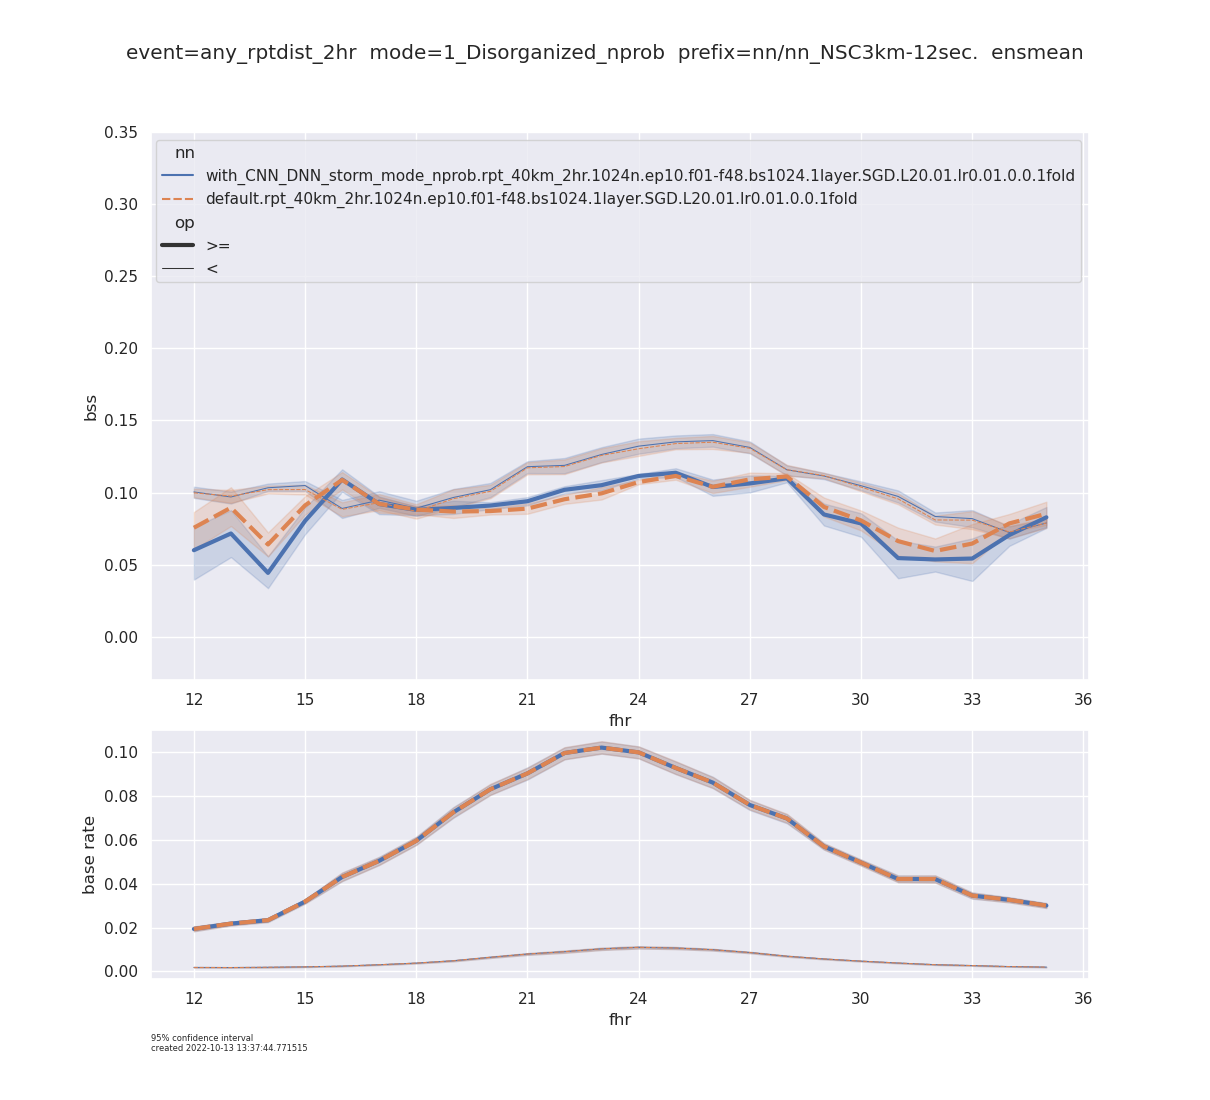

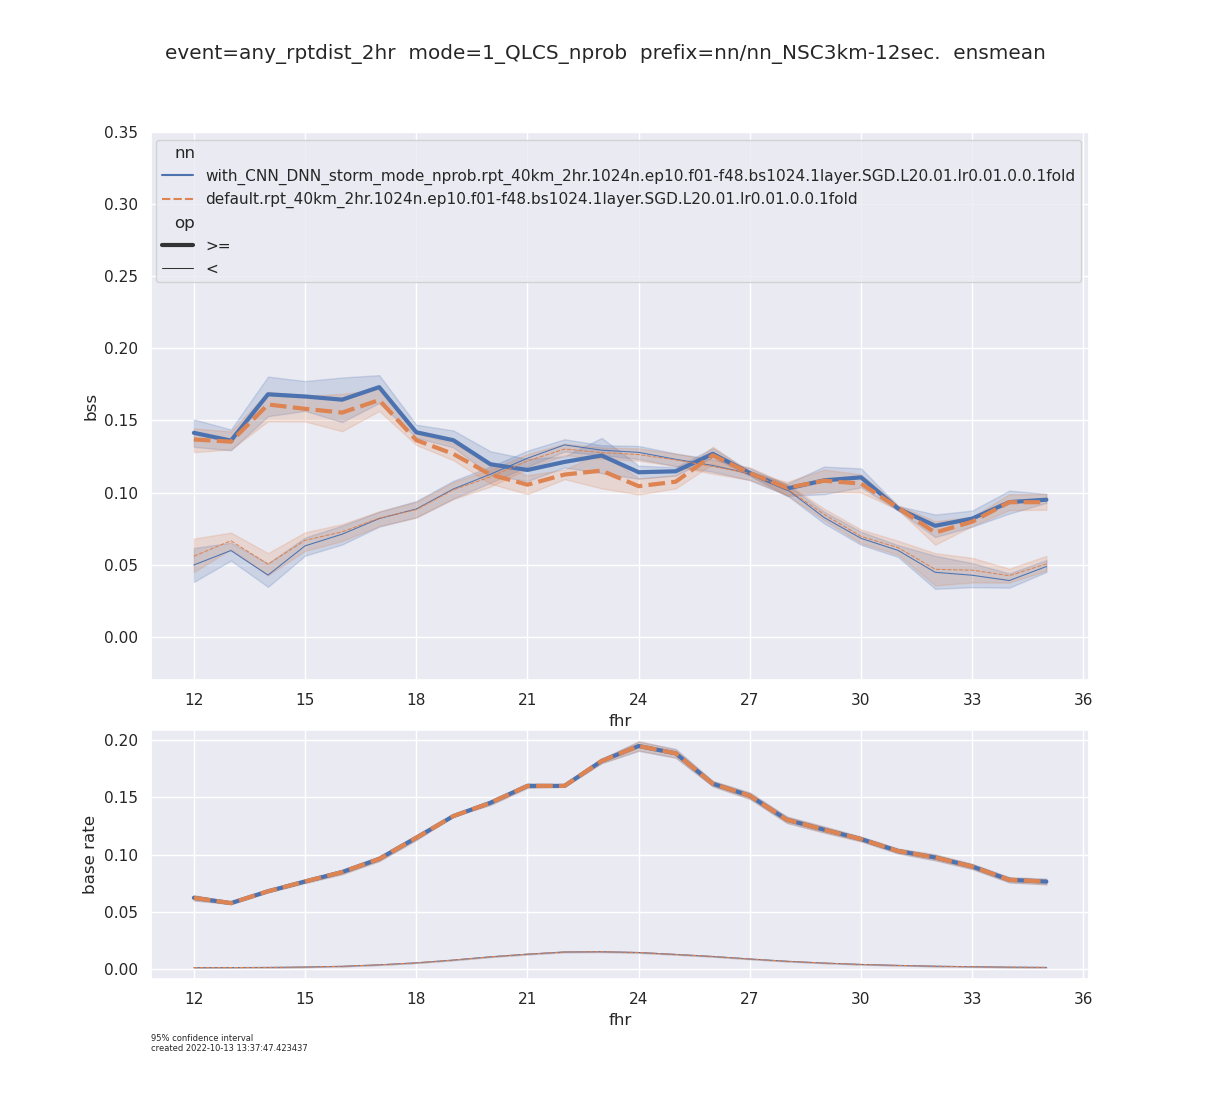

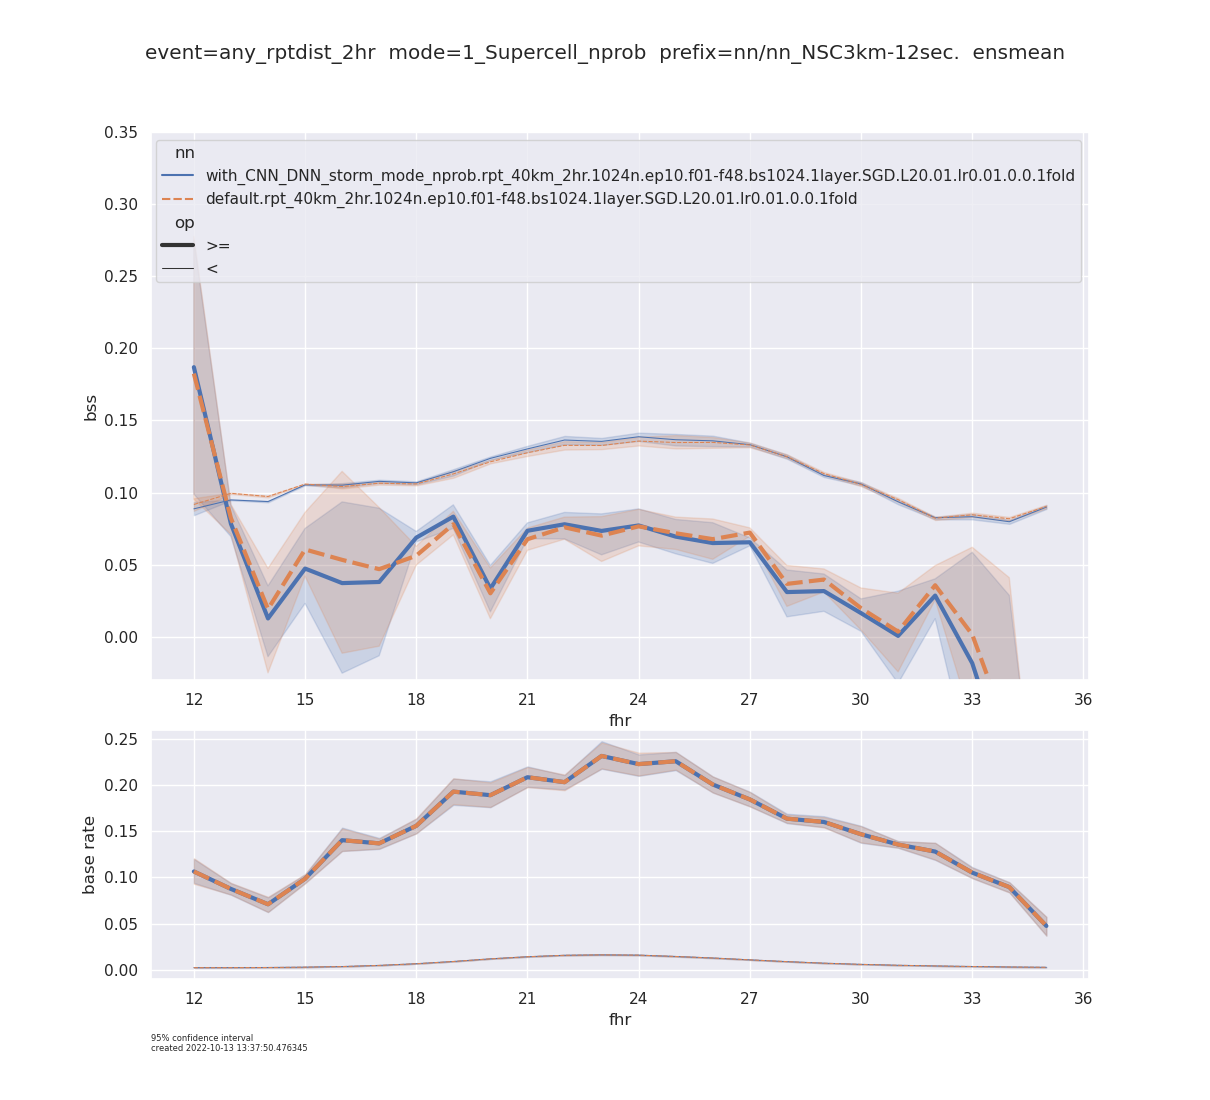

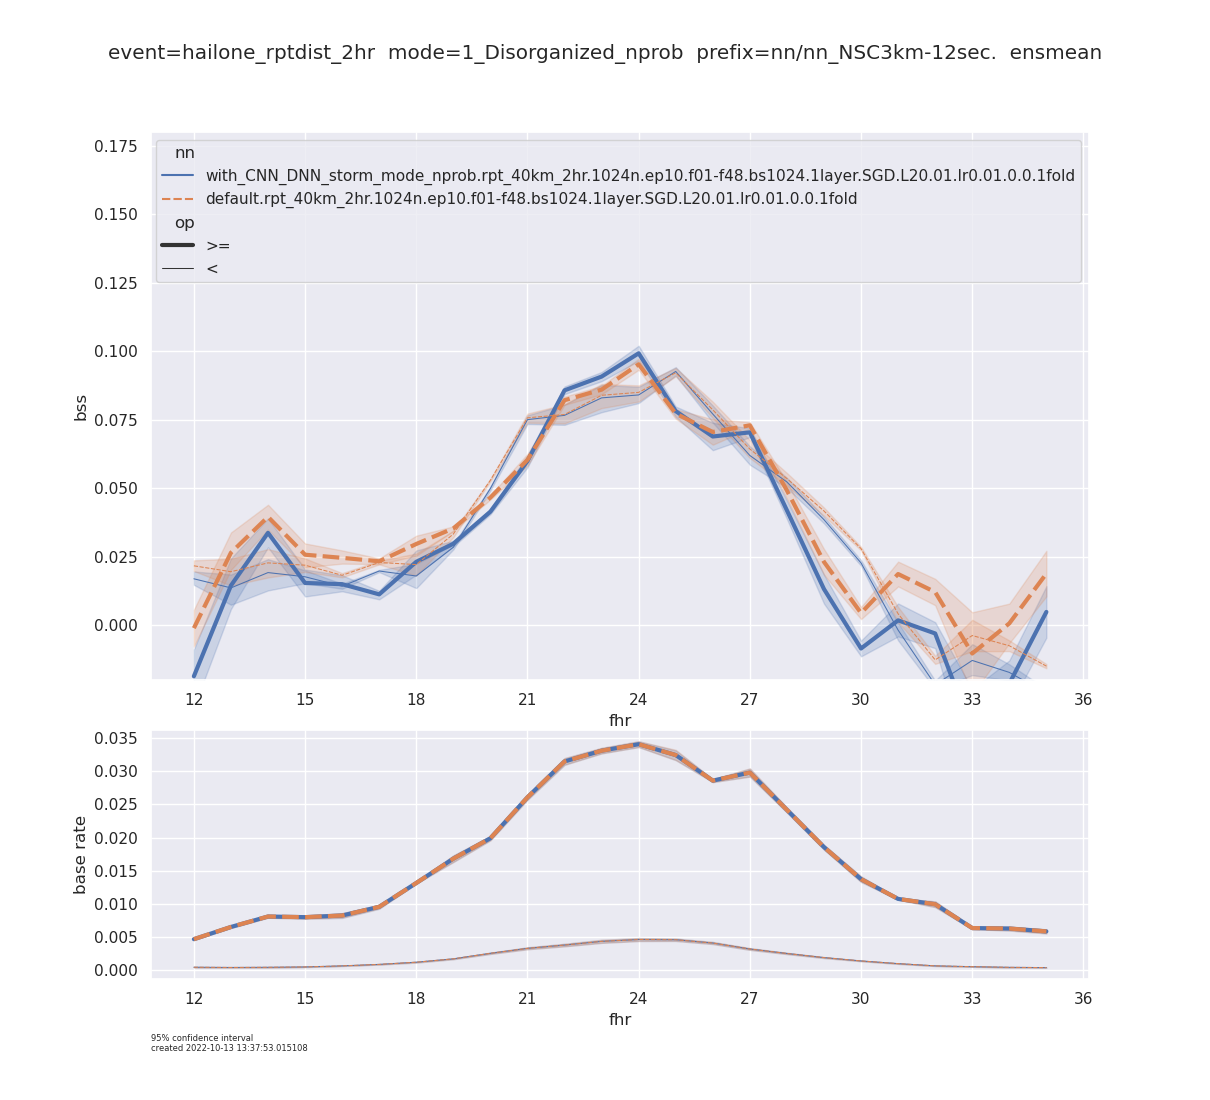

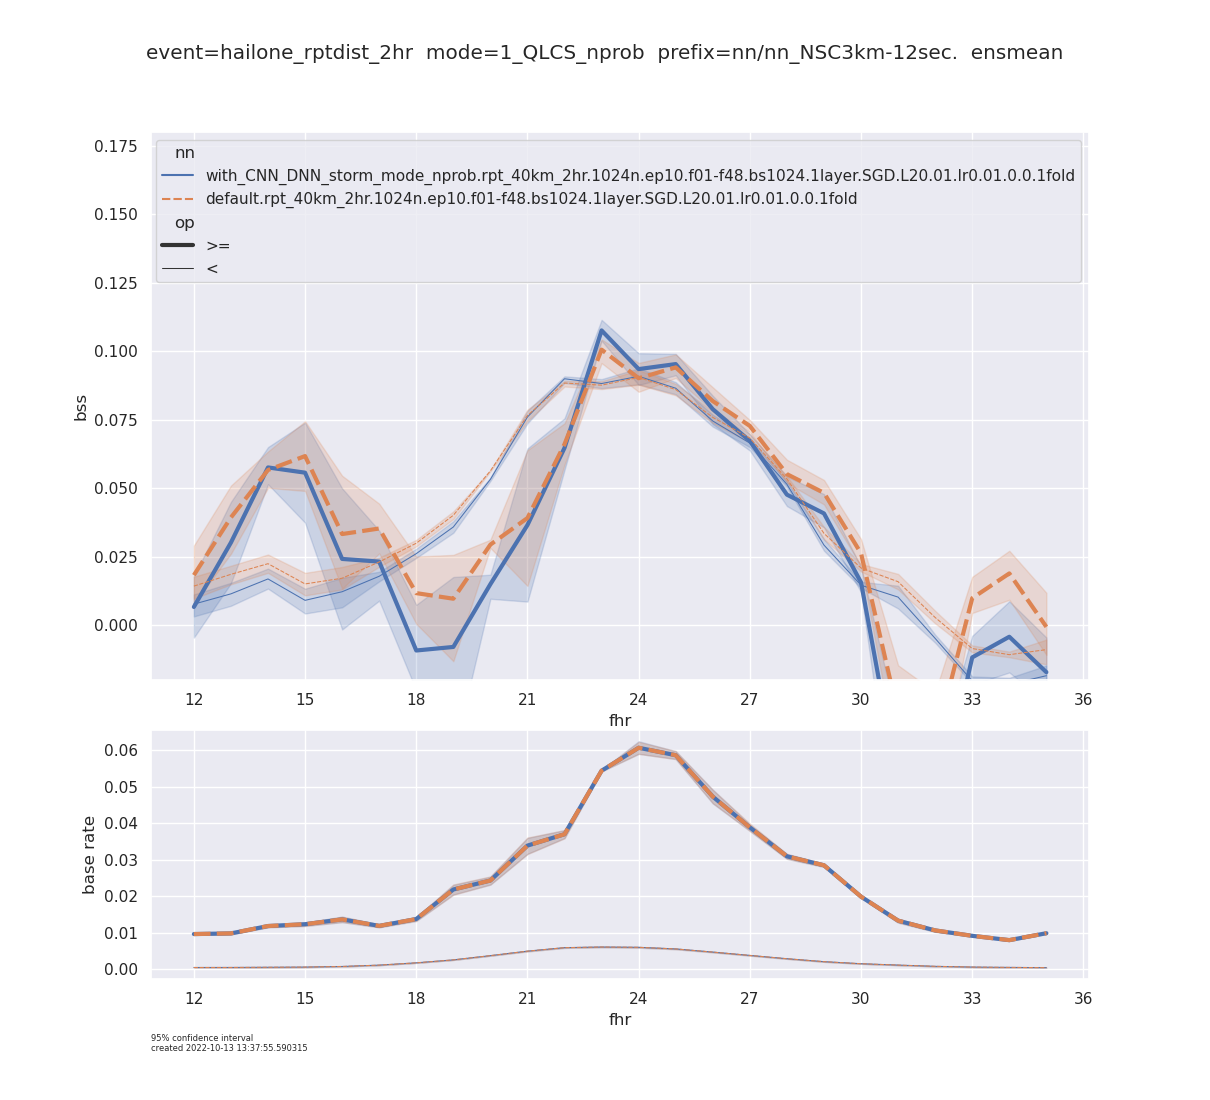

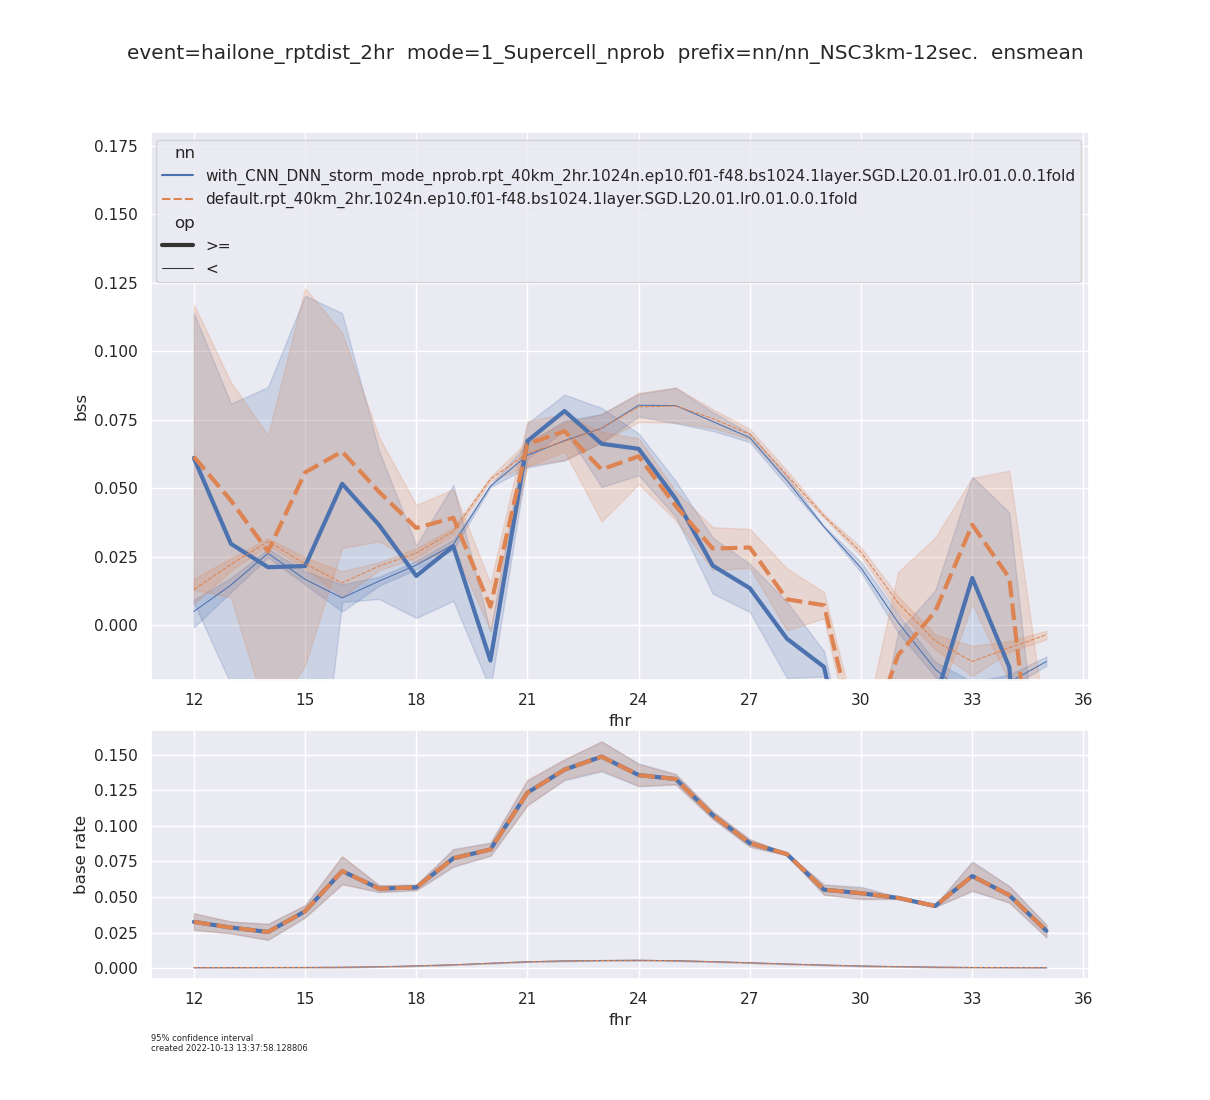

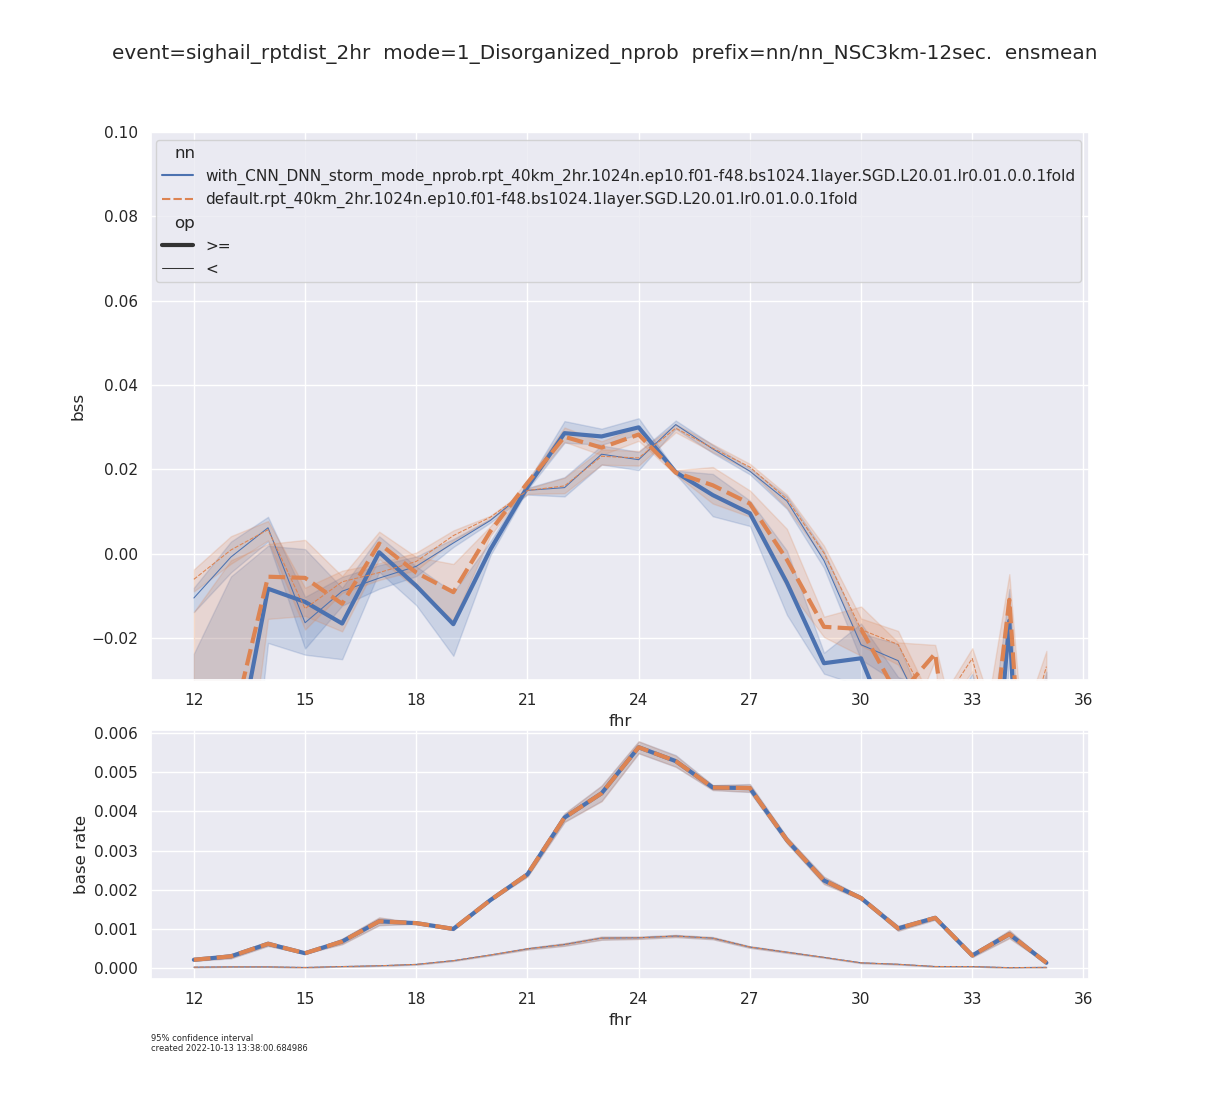

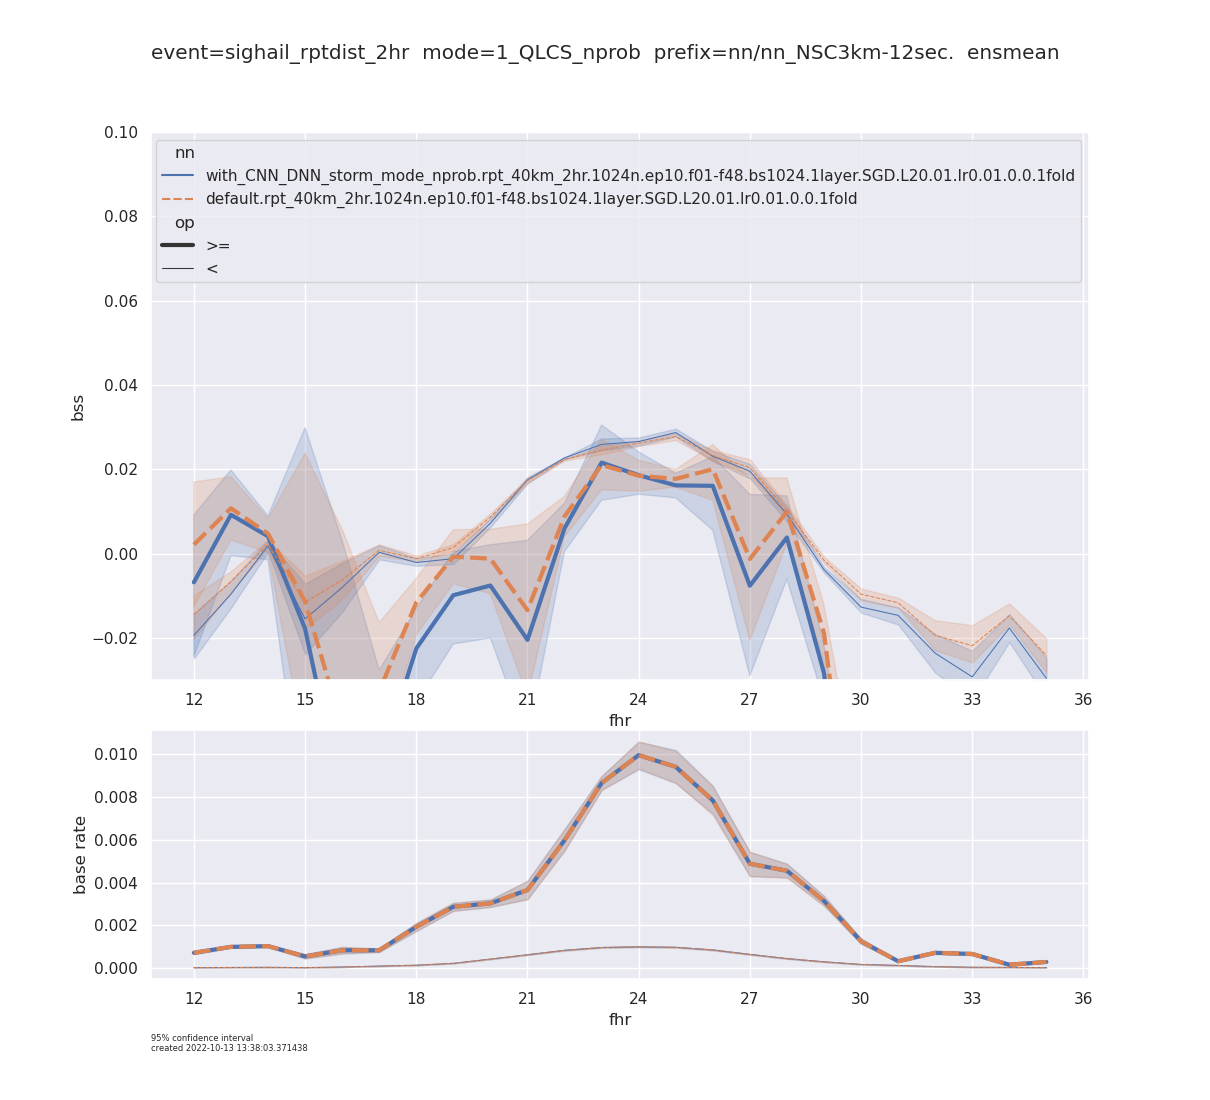

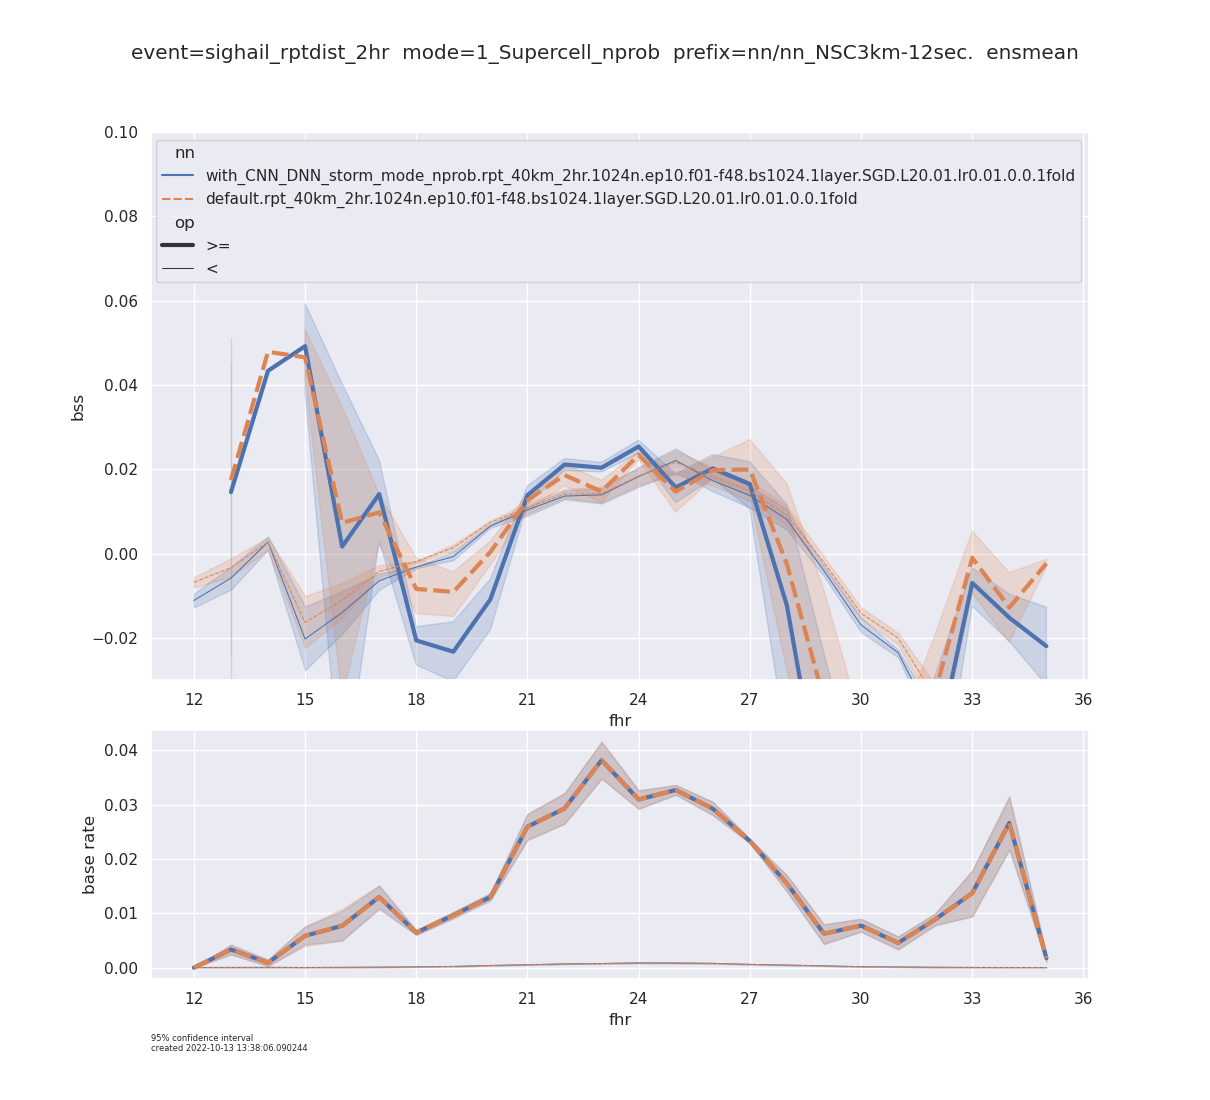

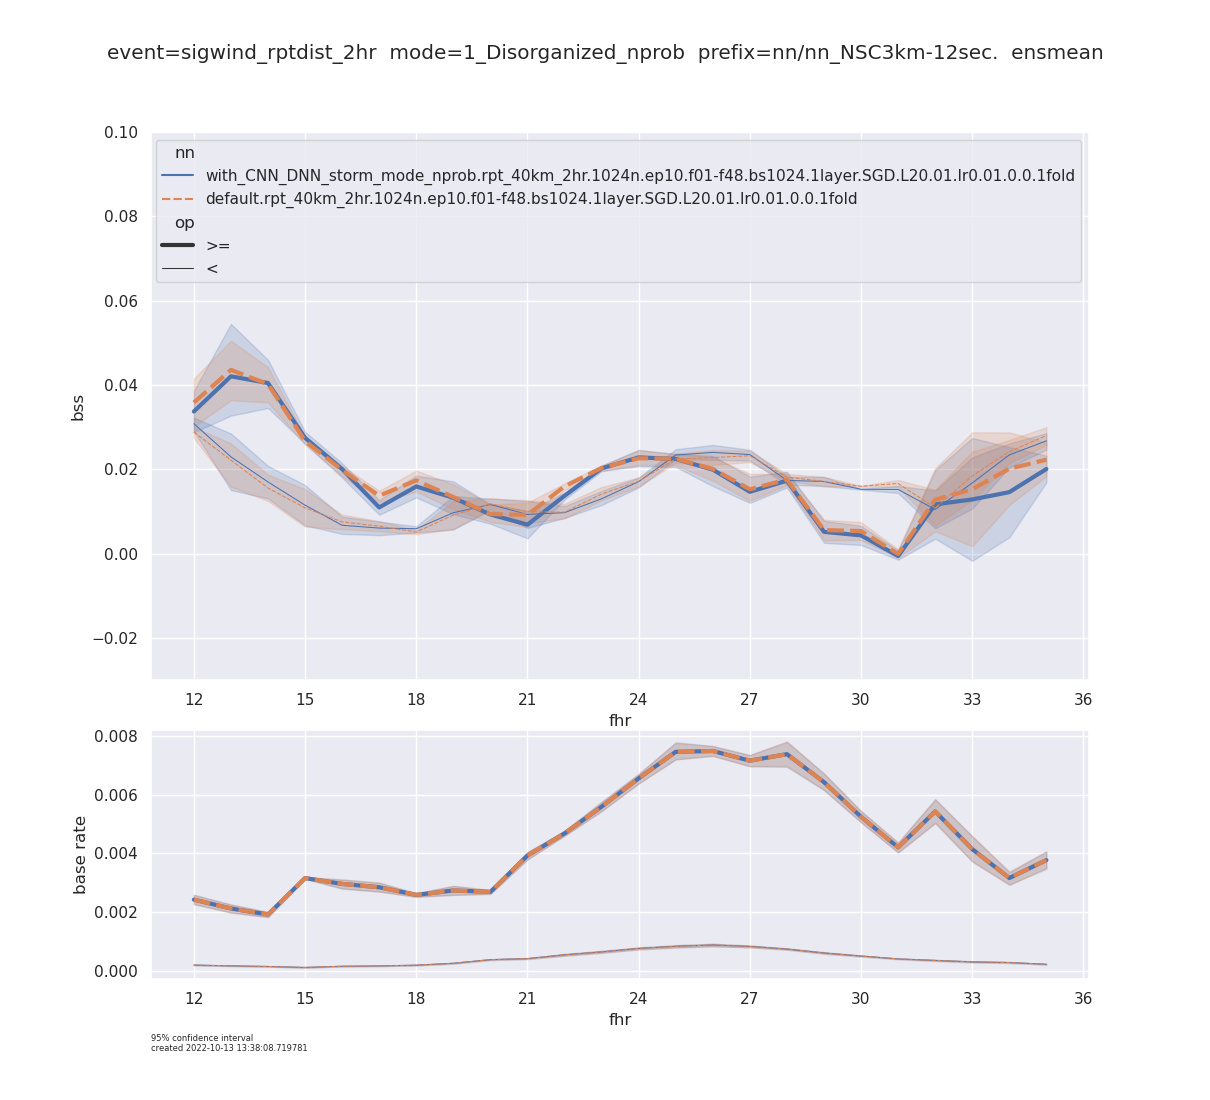

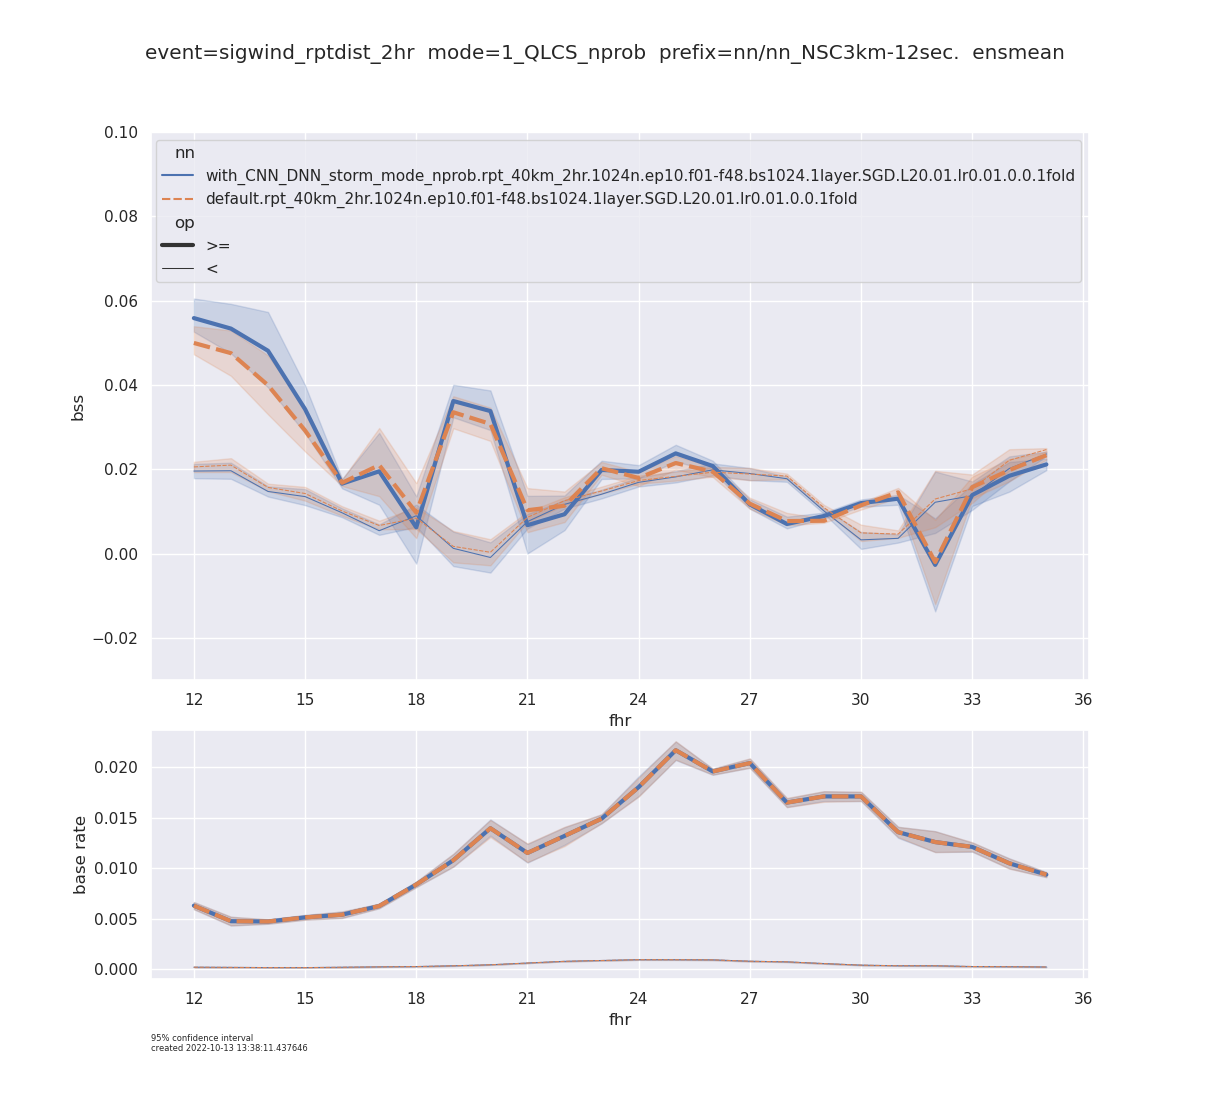

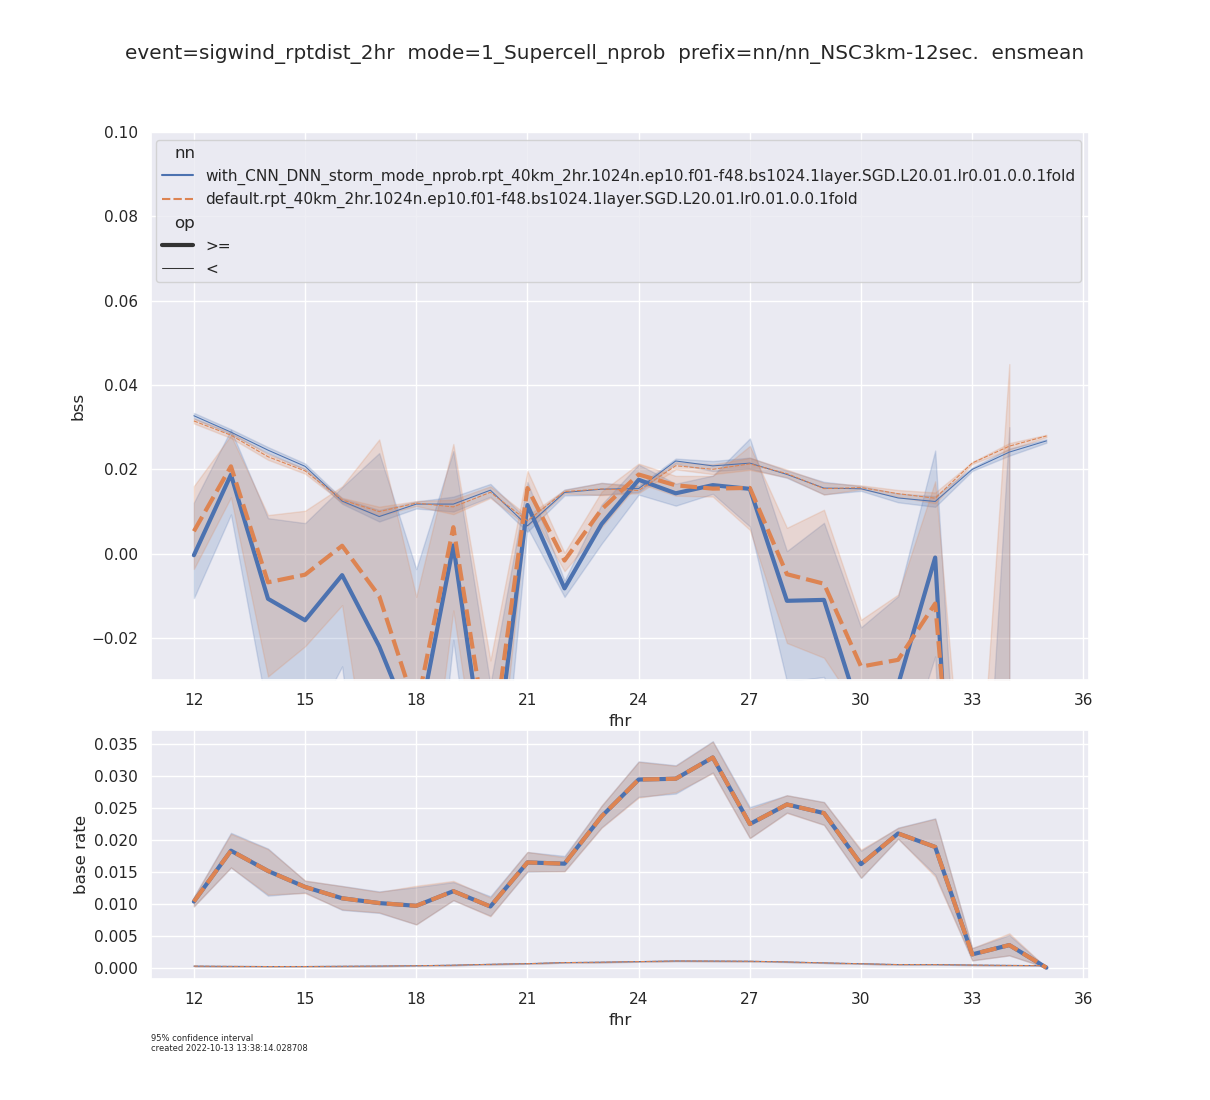

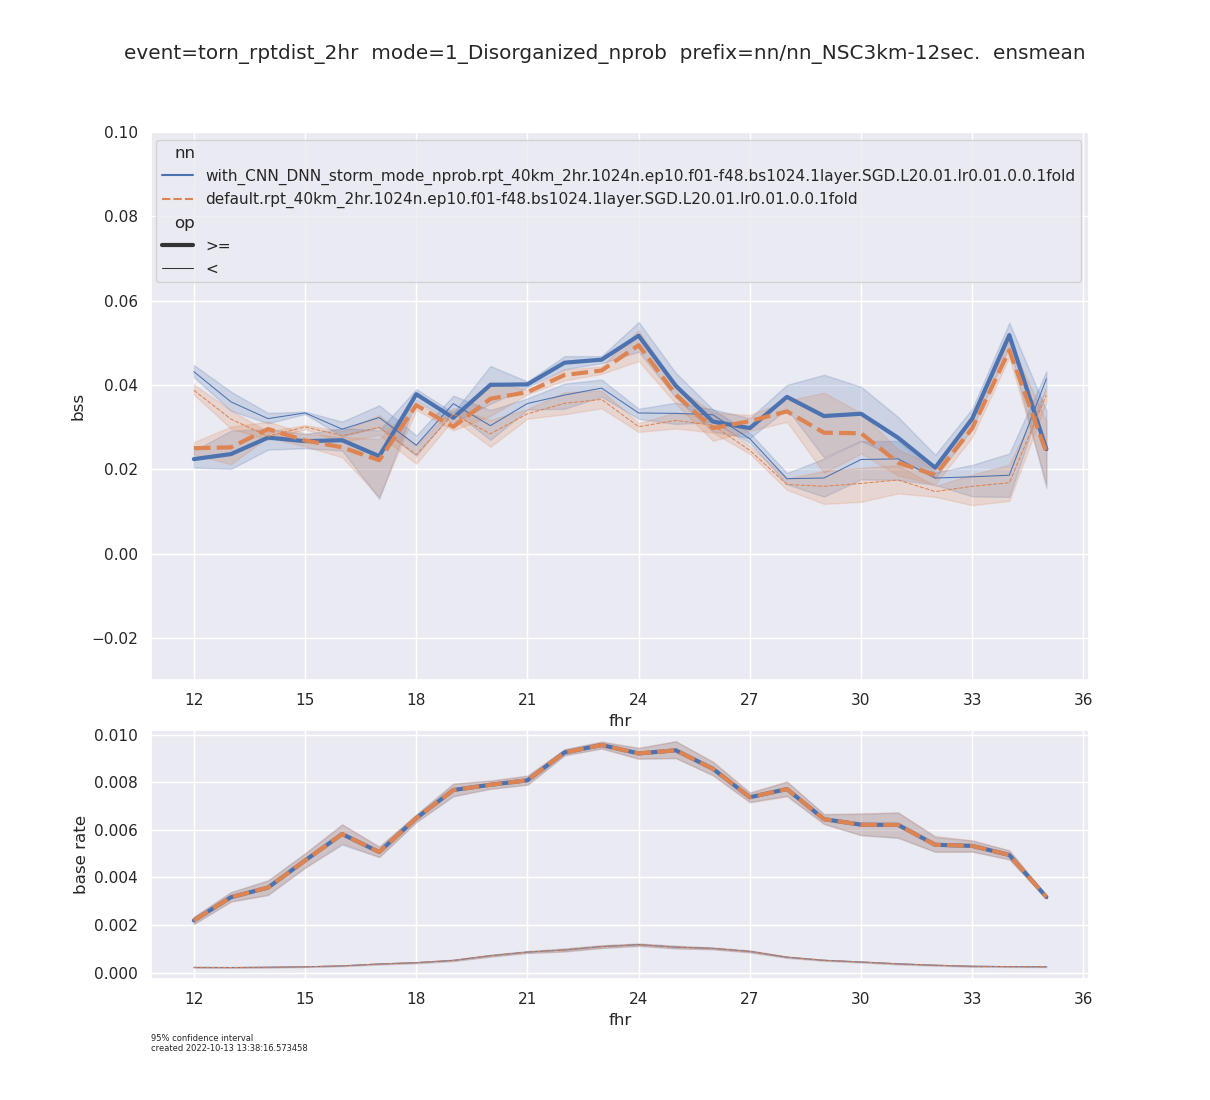

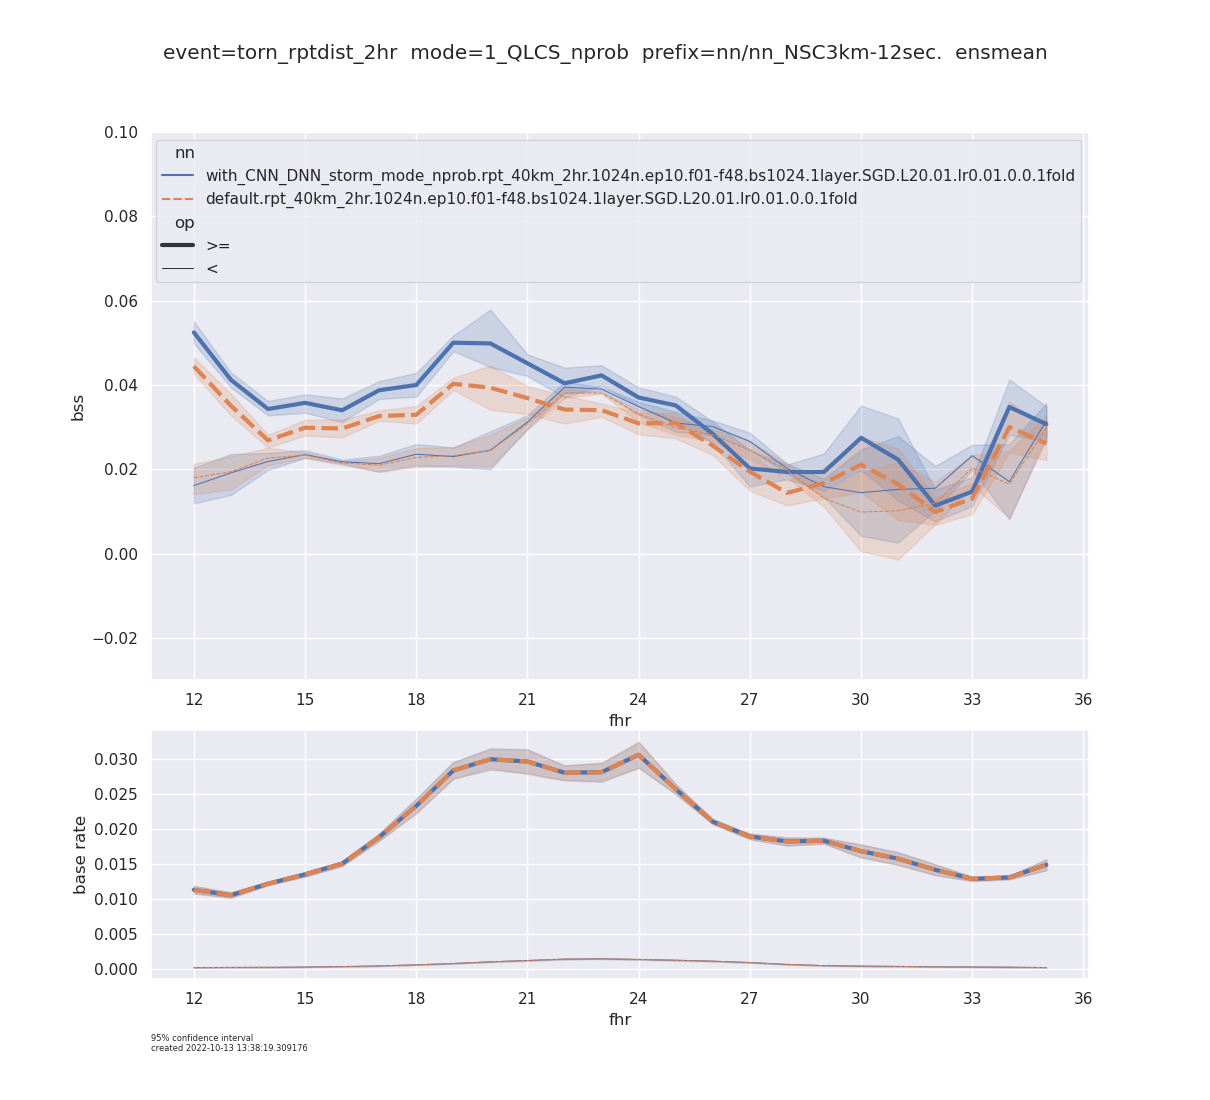

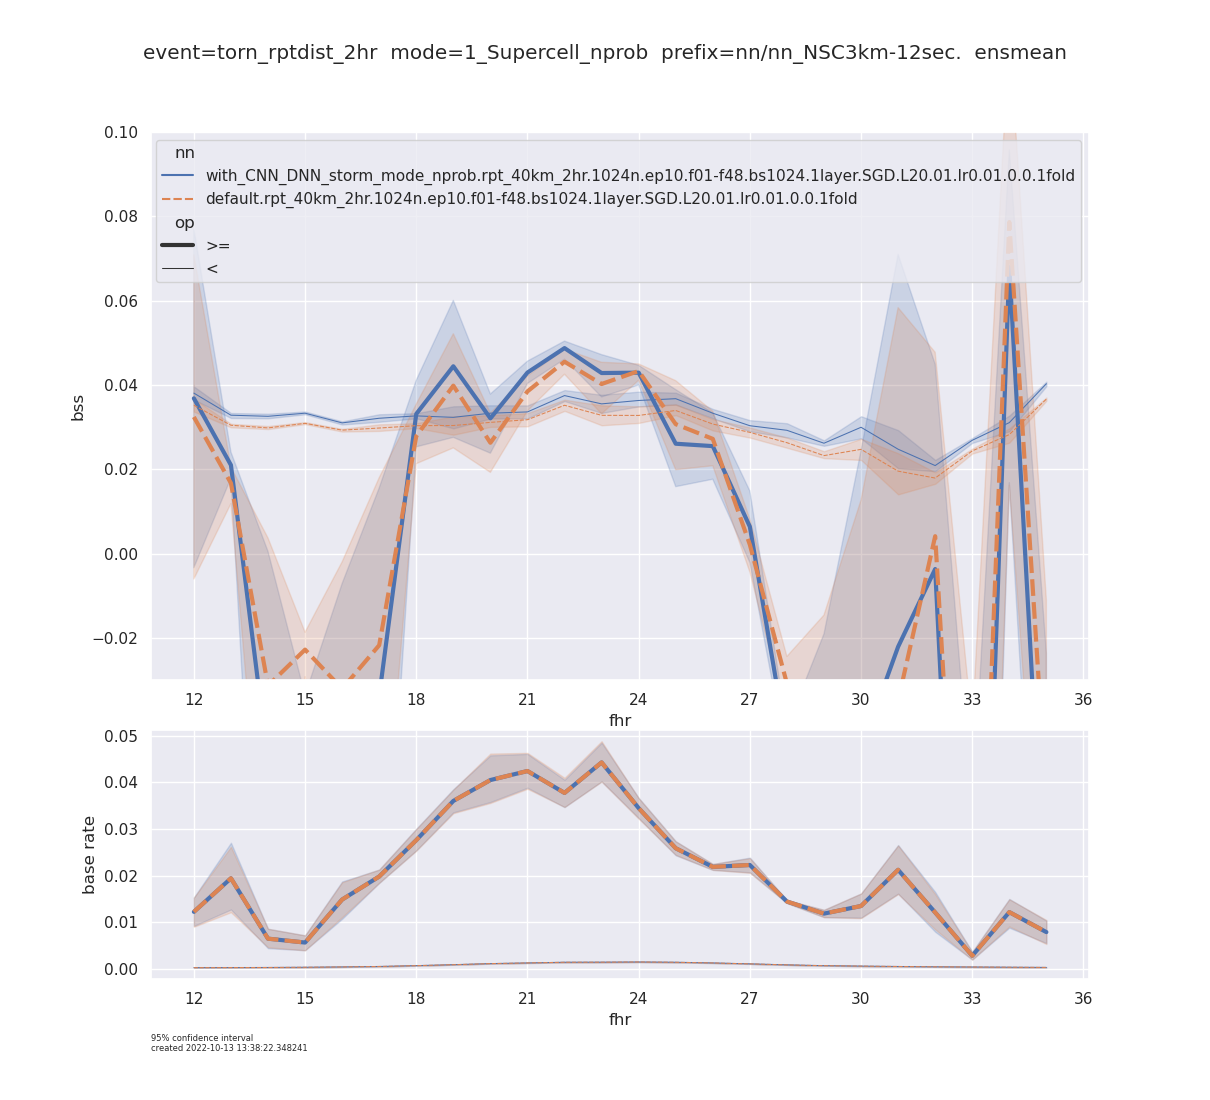

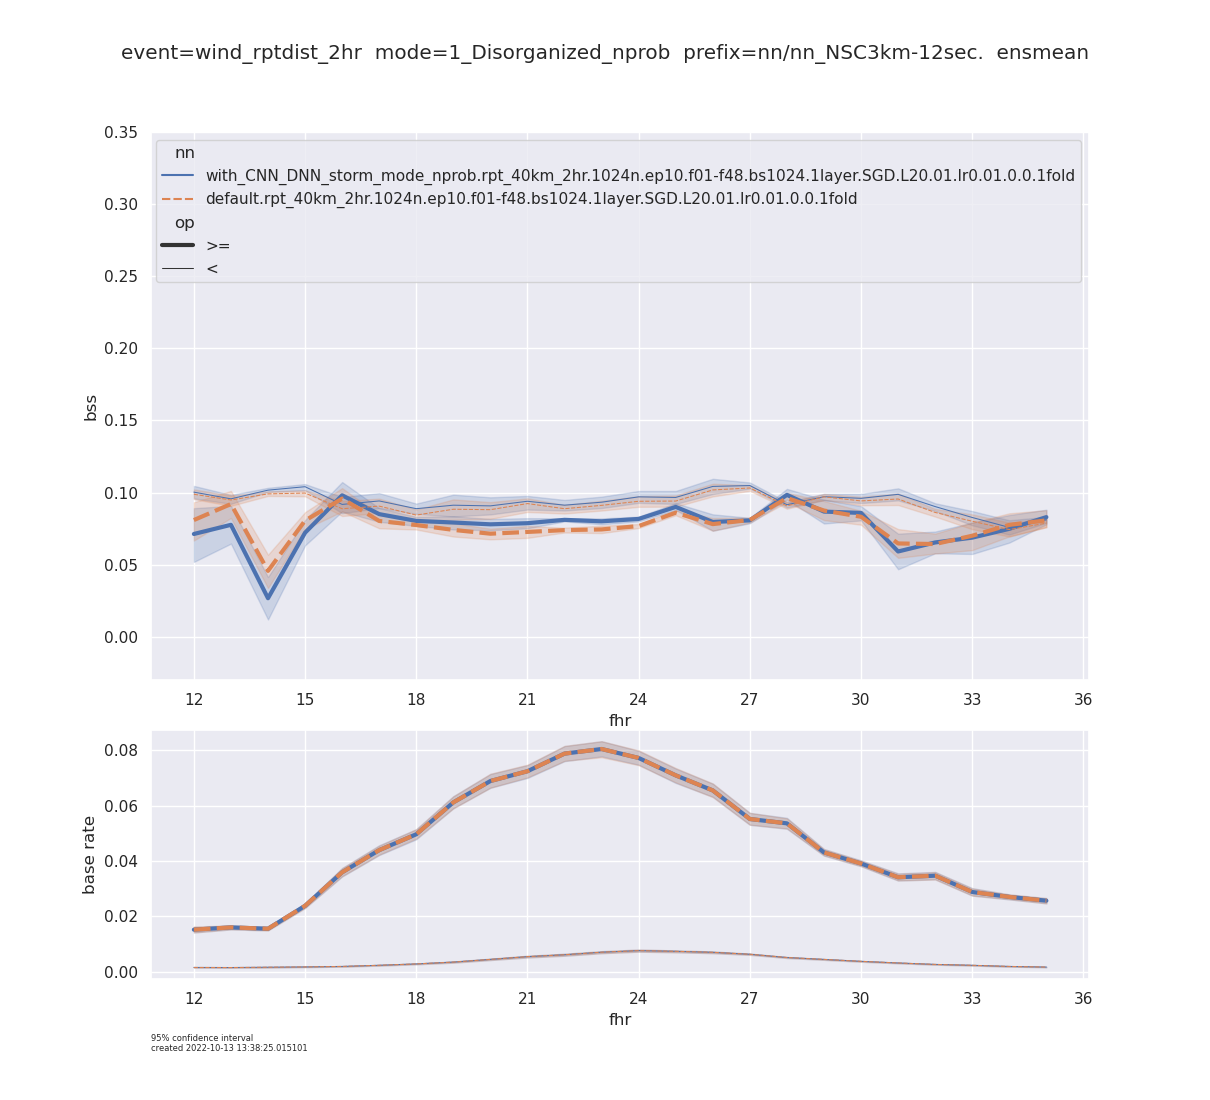

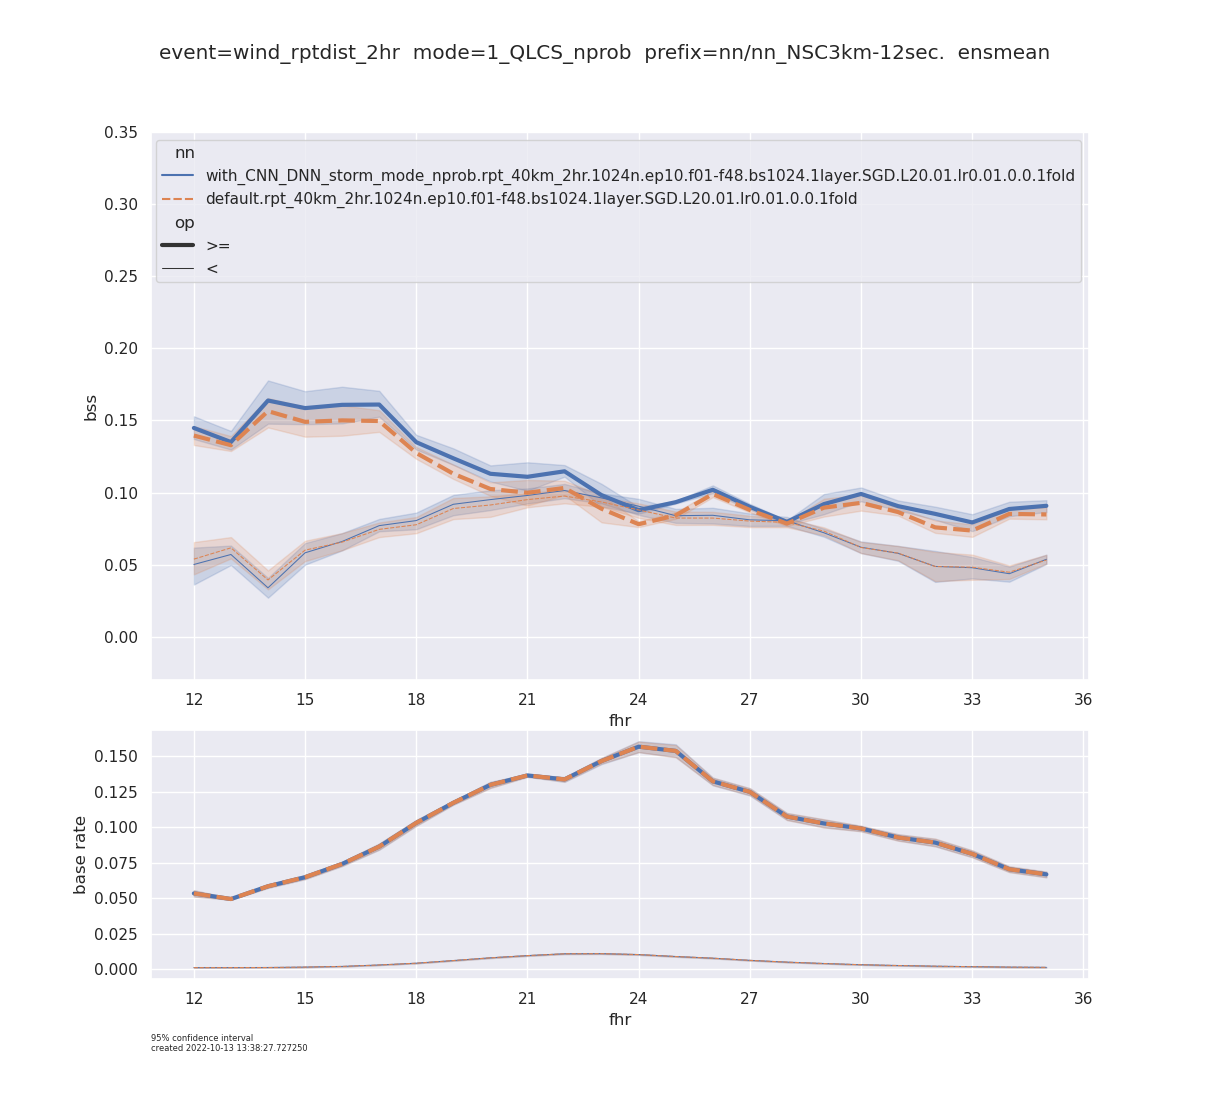

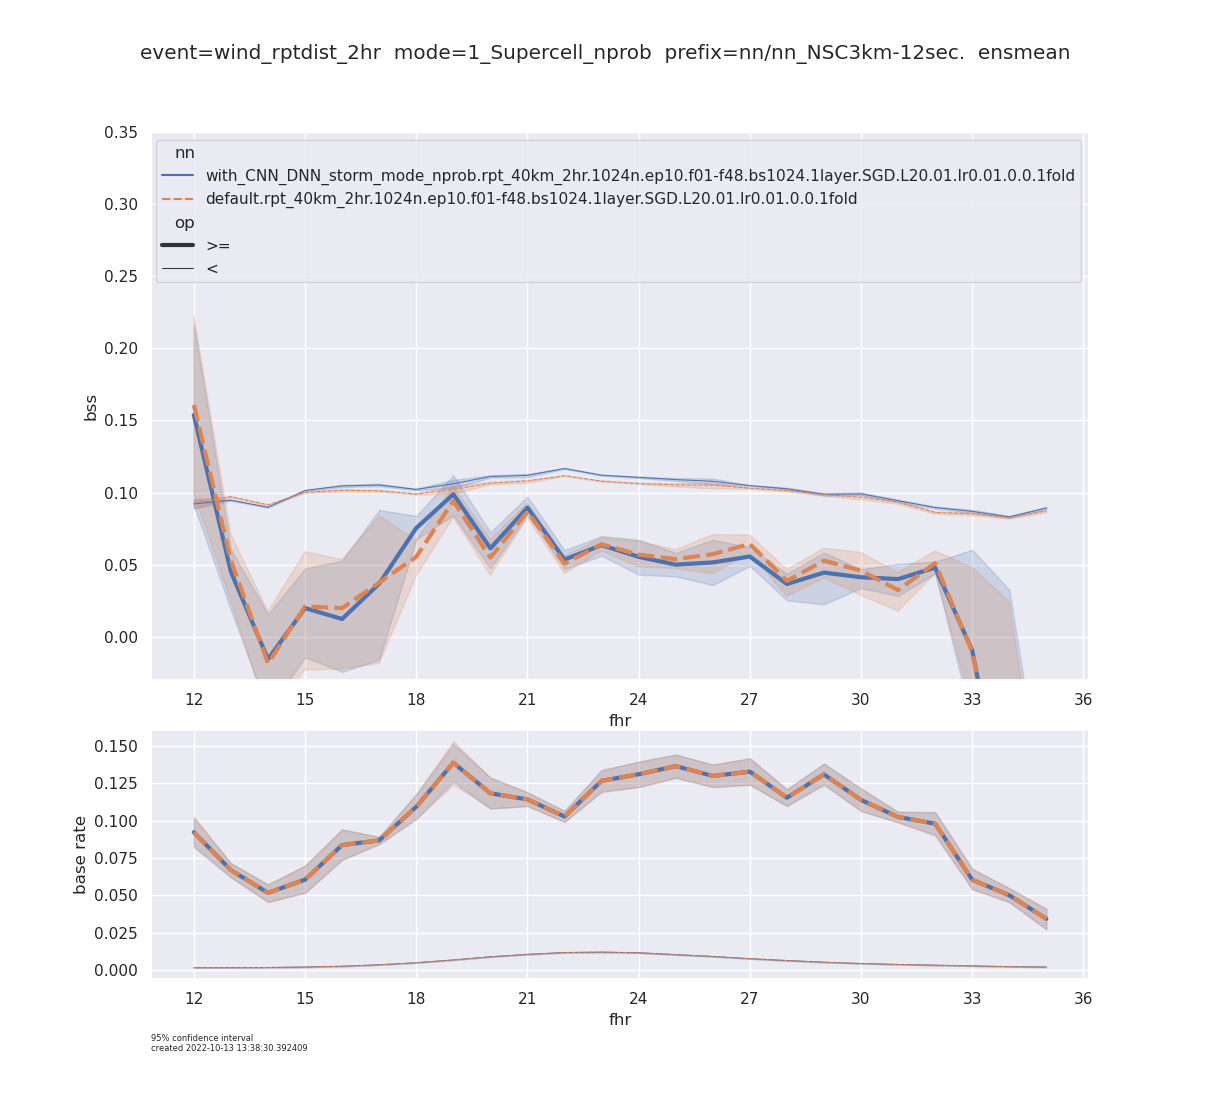

In [15]:
# Figure dimensions, line thicknesses, text alignment
text_kw = dict(fontsize=10, ha="left", va="center", clip_on=True) # clip_on in case variable is so low it squishes botax
# If ci is zero, don't plot confidence band; plot individual lines for all members    
if ci == 0:
    line_kw = dict(units="mem", estimator=None)
else:
    # If ci is not zero plot ci% confidence interval
    line_kw = dict(ci=ci)

order = sorted(dfs.index.levels[3].values, reverse=True) # Why are they in seemingly random order?
line_kw.update(dict(hue="nn", style="nn", size="op", hue_order=order, style_order=order, size_order=[">=","<"]))


# Loop thru types of event (torn, wind, hail, lightning)
# Could add .xs("5%",level="thresh") and/or .xs("CNN",level="model") to focus on one threshold and/or one model
for (cl, mode), df in dfs.groupby(["class","mode"]):
    logging.info(f"{cl} {mode}")
    # Drop fhr=all
    df_all = df.xs("all", level="fhr")
    df = df[df.index.get_level_values("fhr") != "all"]
    df = df.reset_index(drop=False)
    df["fhr"] = df["fhr"].astype(float)
    fig = plt.figure(figsize=(12.1,11))
    st = plt.suptitle(f"\nevent={cl}  mode={mode}  prefix={prefix}")
    topax = plt.subplot2grid((3,1),(0,0), rowspan=2)
    botax = plt.subplot2grid((3,1),(2,0), rowspan=1, sharex=topax)
    # Empty fineprint_string placeholder for fine print in lower left corner of image.
    fineprint = plt.annotate(text="", xy=(0,-55), xycoords=('axes fraction','axes pixels'), va="top", fontsize=6, wrap=True)
    if not nofineprint:
        fineprint.set_text(f"{ci}% confidence interval\ncreated {datetime.datetime.now()}")

    iens = df["mem"] == "ensmean.all"
    if not nomem:
        sns.lineplot(data=df[~iens], x="fhr", y=variable,  ax=topax, **line_kw)
    if ensmean:
        logging.debug("ensemble mean")
        st.set_text(st.get_text()+ "  ensmean")
        sns.lineplot(data=df[iens], x="fhr", y=variable,  ax=topax, **line_kw, legend=nomem)
        if not nomem:
            for i,row in df[iens & (df.fhr == df.fhr.max())].iterrows():
                topax.text(df.fhr.max(), row[variable], "ens. mean", **text_kw)
            topax.set_xlim(topax.get_xlim()[0], topax.get_xlim()[1]+1.2) # add space for "ensmean" label

    # Base rate
    base_rate_ax = botax
    sns.lineplot(data=df, x="fhr", y="base rate", ax=base_rate_ax, legend=False, **line_kw) # ignores color arg
    base_rate_ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

    if variable == "bss":
        ylim = (-0.03,0.35)
        if cl == "flashes": ylim = (0,0.75)
        if cl.startswith("torn") or cl.startswith("sig"): ylim = (-0.03, 0.1)
        if cl.startswith("hailone"): ylim = (-0.02, 0.18)
        topax.set_ylim(ylim)

    if ymax is not None:
        topax.set_ylim(top=ymax)
    if ymin is not None:
        topax.set_ylim(bottom=ymin)

    handles, labels = topax.get_legend_handles_labels()
    if len(handles) > 8:
        topax.legend(handles, labels, ncol=2, fontsize=7, labelspacing=0.45, columnspacing=1, title=prefix,
                handlelength=3, title_fontsize=8) #default handlelength=2

            